 # Creating New data set

In [11]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point, Polygon
from pyproj import CRS
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import folium
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMap#, heat_map_withtime, HeatMapWithTime
from folium.plugins.heat_map_withtime import HeatMapWithTime
from sklearn.neighbors import KernelDensity

In [12]:
# Load the dataset into a DataFrame
df_test = pd.read_csv('data/Test_data.csv')
df_train_labels= pd.read_csv('data/training_label.csv')
df_train_values = pd.read_csv('data/training_values.csv')

In [13]:
# Merging datasets
df_merged = df_train_values.merge(df_train_labels,how='left',on='id')
# Checking Shape after merge
df_merged.shape

(59400, 41)

In [14]:
# Read in shp
bound = gpd.read_file('regions/Regions.shp')

Converting df to gdf

In [15]:
gdf = gpd.GeoDataFrame(df_merged, 
                       geometry=gpd.points_from_xy(df_merged['longitude'], df_merged['latitude']), 
                       crs= CRS.from_epsg(4326))

In [16]:
# creating weight column
weight_functional = {'functional': 3, 'non functional': 1, 'functional needs repair': 2}
gdf['weight'] = gdf['status_group'].map(weight_functional)

Spatially joinning dataframes

In [17]:
#1
bound = bound.to_crs(gdf.crs)
gdf_1 = gpd.sjoin(gdf, bound, how='inner')

In [8]:
#gdf_1.to_csv('gis_waterwells.csv', index=False)

In [16]:
# Checking length of DataFrames
def length(*args):
    '''
    args: input dataframes 
    Example: length(df1, df2, df10)
    '''
    for df in args:
        df_names = ''.join([name for name, value in globals().items() if value is df])
        print(f'Length of {df_names}: \033[1m{len(df)}\033[0m')

In [18]:
# Checking the length of the dataframes and making sure that df and gdf length match each other
length(df_merged,gdf,gdf_1)

Length of df_merged: 59400
Length of gdf: 59400
Length of _gdf_1_14: 57469


In [8]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# Creating JSON File


In [18]:
import geopandas as gpd
from shapely.geometry import Point, Polygon, mapping, box
import json
# buffer = np.sqrt(1591.0131945328516849)

# create buffer around each point to make a square
buffer_distance = 1000 #meters
gdf_j1 = gdf_1.copy()
# crs EPSG:32610 is in meters 3395  3857   32634
# 32726 is more accurate in this region and will cause less distortion
p_gdf1 = gdf_j1.to_crs('EPSG:32736')
# gdf_squares = p_gdf.buffer(buffer_distance)
gdf_squares1 = p_gdf1.buffer(buffer_distance, cap_style=3)

# reproject the buffer polygons back to original CRS
gdf_squares1 = gdf_squares1.to_crs(gdf_j1.crs)

# create GeoDataFrame of polygons
gdf_polygons1 = gpd.GeoDataFrame(gdf_j1,geometry=gdf_squares1, crs=gdf_j1.crs)

# # add price column to polygons GeoDataFrame
# gdf_polygons1['price'] = gdf_j1['price']

# gdf_polygons.index = gdf_j1['id']
# # gdf_polygons['id'] = gdf_j['id']
# gdf_polygons = gdf_polygons.reset_index()
# gdf_polygons.index = gdf_j['id']

geojson1 = gdf_polygons1.to_json()

In [19]:
lat_min, lat_max = gdf_1['latitude'].min(), gdf_1['latitude'].max()
long_min, long_max = gdf_1['longitude'].min(), gdf_1['longitude'].max()

In [24]:
gdf_1['latitude'].max()

-0.99952232

In [25]:
lat_max

-0.99952232

In [20]:
# map colors
dark_map = 'cartodbdark_matter'
stamentoner = "stamentoner"
light_map = 'cartodbpositron'
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
YOR = 'YlOrRd'
YGB = 'YlGnBu'
cool = 'cool'
copper = 'copper' # Good for showing only high values on dark_map
winter ='winter' # blue to green
autumn = 'autumn' # Red to orange - would be better flipped
autunm_fliped = 'autumn_r' # yellow to red          ************ best one ********
bone = 'bone' # works on light backgrounds probably better flipped
hsv = 'hsv' # cyclic map - would look really cool mapped with the coef to show max impact of both positive and neg

def choropleth(data, weight, color, **kwargs):
    '''
    data : data with polygons
    color : cmap color
    
    '''
    # plot the choropleth map
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # point color is set to weight, based on status_group 
    data.plot(column=weight, cmap=color, linewidth=1, ax=ax, marker='s', **kwargs)
    
    # Setting the location of map
    lat_min, lat_max = gdf_1['latitude'].min(), gdf_1['latitude'].max()
    long_min, long_max = gdf_1['longitude'].min(), gdf_1['longitude'].max()
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlim(long_min, long_max)

    ctx.add_basemap(ax, crs=data.crs,source= dark_map , alpha=.7)
    ax.axis('off')

    # adding color bar
    vmin, vmax = gdf['weight'].min(), gdf['weight'].max()
    tick = [1,2,3]
    labels = ['non functional', 'functional needs repair', 'functional']
    sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax,shrink=.5, ticks=tick)#,label= labels)
    cbar.ax.set_yticklabels(labels)
    
    
    plt.savefig('well_locations3.png', dpi=200, bbox_inches='tight')
    plt.show()

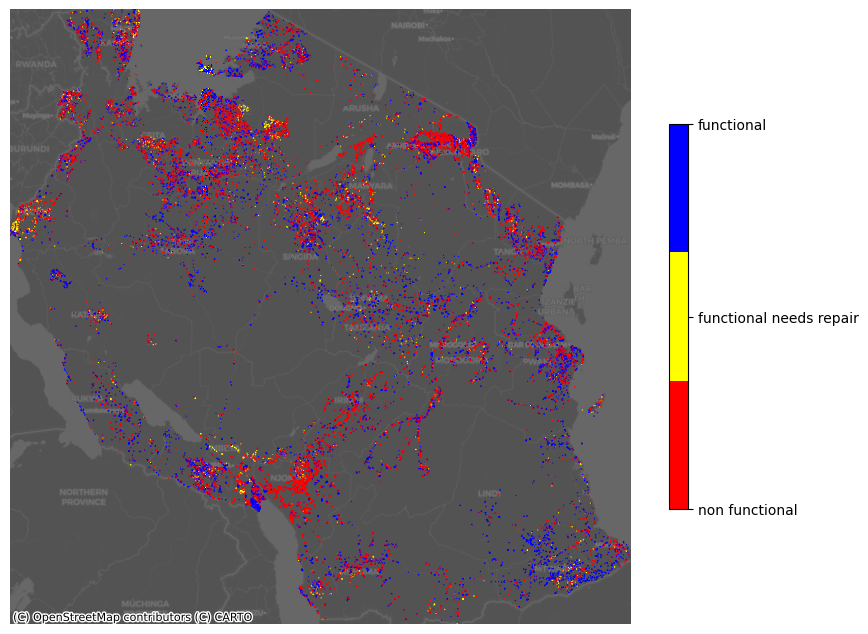

In [21]:
import matplotlib.colors as colors
choropleth(gdf_polygons1,'status_group', colors.ListedColormap(['red', 'yellow', 'blue']))#, vmin=1 , vmax= 3)

In [265]:
gdf_polygons1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'geometry', 'MHHI1',
       'traffic_de', 'toxic_rele', 'hazardou_2', 'SCHDST', 'NAME', 'DSTNUM'],
      dtype='object')

In [56]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [308]:
(gdf_polygons1['sqft_lot'] < 1100).sum()

786

In [51]:
def folium_cluster(df, column, metrics=False, **kwargs):
    '''
    Function creates a folium cluster map,
    
    df : dataframe - must have columns 'lat' and 'long'
    column : name 'column' 
                Used for cluster weight
    metrics : defalut = 0 (makes all icons be red)
            Cluster threshold metric 
            (mean,median,mode, or specific int/float value)
                
    **kwargs are for folium.Map,
    This is a list of the most common arguments/default values:
    width='100%', height='100%', tiles='OpenStreetMap', min_zoom=0, max_zoom=18, zoom_start=10
    '''
    # Code to determine metrics
    if metrics == 'mean':
        metric = df[column].mean()
        print(f'Mean:{metric}')
    elif metrics == 'median':
            metric = df[column].median()
            print(f'Median:{metric}')
    elif metrics == 'mode':
            metric = int(df[column].mode())
            print(f'Mode:{metric}')
    elif type(metrics) == int: 
            metric = metrics
    else:
        metric = 'false'
            
    # Create a folium map, this is centered at the mean latitude and longitude 
    folium_map = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],**kwargs)


    # Create a list of tuples containing the latitude and longitude for each data point
    data_values = zip(df['latitude'], df['longitude'],df[column])
   
    # callback functions need to be in javascript to be run, this is adapted from:
    # https://github.com/python-visualization/folium/blob/main/examples/MarkerCluster.ipynb
    callbacks = f"""\
    function (row) {{
        var icon, marker, value;
        value = row[2]; // assuming the column is the 3rd column in the dataframe
        if ({metric} == false) {{
            icon = L.AwesomeMarkers.icon({{icon: "map-marker", markerColor: "green"}});
        }} else if (value > {metric}) {{
            icon = L.AwesomeMarkers.icon({{icon: "map-marker", markerColor: "red"}});
        }} else {{
            icon = L.AwesomeMarkers.icon({{icon: "map-marker", markerColor: "blue"}});
        }}
        marker = L.marker(new L.LatLng(row[0], row[1]));
        marker.setIcon(icon);
        return marker;
    }};
    """
    
    # Add the marker cluster layer to the map
    folium.plugins.FastMarkerCluster(data_values, callback=callbacks).add_to(folium_map)
    
    # Display the map
    display(folium_map)
#     map_houses.save('cluster_map.html')

In [52]:
folium_cluster(gdf,'weight')

In [17]:
# map colors
dark_map = 'cartodbdark_matter'
stamentoner = "stamentoner"
light_map = 'cartodbpositron'
#https://matplotlib.org/stable/tutorials/colors/colormaps.html
YOR = 'YlOrRd'
YGB = 'YlGnBu'
cool = 'cool'
copper = 'copper' # Good for showing only high values on dark_map
winter ='winter' # blue to green
autumn = 'autumn' # Red to orange - would be better flipped
autunm_fliped = 'autumn_r' # yellow to red          ************ best one ********
bone = 'bone' # works on light backgrounds probably better flipped
hsv = 'hsv' # cyclic map - would look really cool mapped with the coef to show max impact of both positive and neg

def choropleth(data, weight, color, **kwargs):
    '''
    data : data with polygons
    color : cmap color
    
    '''
    # plot the choropleth map
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # point color is set to weight, based on status_group 
    data.plot(column=weight, cmap=color, linewidth=1, ax=ax, marker='s', **kwargs)
    
    # Setting the location of map
    lat_min, lat_max = gdf_1['latitude'].min(), gdf_1['latitude'].max()
    long_min, long_max = gdf_1['longitude'].min(), gdf_1['longitude'].max()
    ax.set_ylim(lat_min, lat_max)
    ax.set_xlim(long_min, long_max)

    ctx.add_basemap(ax, crs=data.crs,source= dark_map , alpha=.7)
    ax.axis('off')

    # adding color bar
    
    sm = plt.cm.ScalarMappable(cmap=color)
    cbar = plt.colorbar(sm, ax=ax,shrink=.5, )#,label= labels)
   
    
    
    plt.savefig('well_locations.png', dpi=200, bbox_inches='tight')
    plt.show()

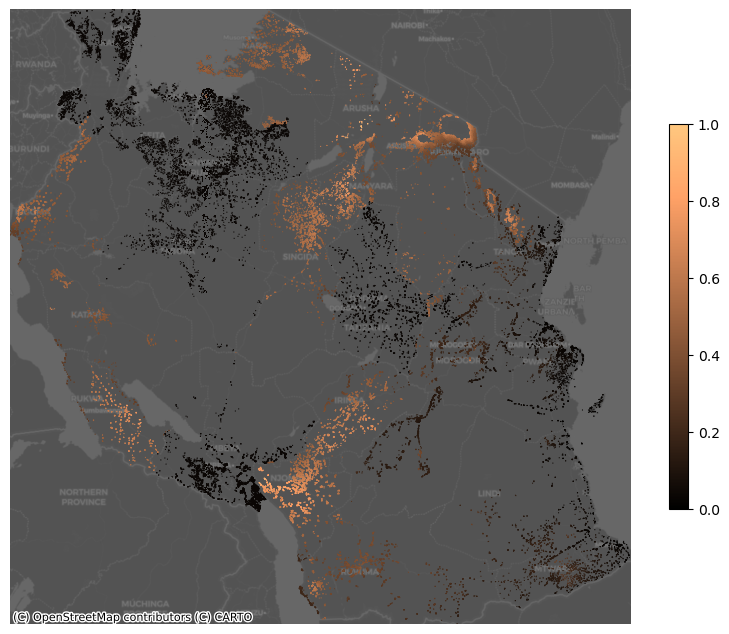

In [18]:
import matplotlib.colors as colors
choropleth(gdf_polygons1,'gps_height', copper)#, vmin=1 , vmax= 3)